In [1]:
# Set number of threads to use
import os
nthreads = 24
os.environ["MKL_NUM_THREADS"] = str(nthreads)
os.environ["NUMEXPR_NUM_THREADS"] = str(nthreads)
os.environ["OMP_NUM_THREADS"] = str(nthreads)

In [2]:
import sys

In [3]:
sys.path.insert(1,'../CoreFunctions/')

In [4]:
from JSTA import *

# Load the simulated data
spots: spatial transcriptomics data
nuclei: coordinates of the nuclei pixels, with id numbers

In [5]:
pref = '../simulated_example/'
# load spots
with open(pref+'spots.npy', 'rb') as f:
    spots = np.load(f, allow_pickle=True)
    spots = pd.DataFrame(spots)
    spots.columns = ['x', 'y', 'z', 'gene']
    spots = spots.loc[:, ['gene', 'x', 'y', 'z']]
# load nuclei
with open(pref+'nuclei.npy', 'rb') as f:
    nuclei = np.load(f, allow_pickle=True)
    nuclei = pd.DataFrame(nuclei)
    nuclei.columns = ['id', 'x', 'y', 'z']


Ensure the nuclei start at 0 and end at the number of nuclei - 1  
Some nuclei get filtered out during simulation, and the ids are not updated.  
This may also be the case during preprocessing and nuclei segmentation in real data  

In [6]:
for i, nuc_id in enumerate(np.unique(nuclei.id)):
    nuclei.loc[nuclei.id == nuc_id,'id'] = i

Get the unique genes from the dataset

In [7]:
all_genes = np.unique(spots.gene)

# Run density estimation:
We use a KNN based density estimation to get the local density at each pixel:    
  
$$\frac{\textit{num_spots_around}}{\frac{4}{3}{\pi}r^{3}}$$  
  
pixel_length: edge length of each pixel in microns. (Lower is higher resolution)  
num_spots_around: Number of transcripts on which to find the volume

In [8]:
num_spots_around = 5
pixel_length = 1
pixels = fast_de_all_spots(spots, pixel_length, num_spots_around)
locations = get_locations(spots, pixel_length)

Abcb1a 0
Adamts9 1
Aqp4 2
Arap2 3
Cacna2d1 4
Cadps2 5
Calb1 6
Cdh24 7
Chrm2 8
Clic6 9
Cntn5 10
Cntnap5a 11
Copg2 12
Cspg5 13
Cxcl14 14
Dlx6os1 15
Dmkn 16
Etv5 17
Fezf2 18
Fibcd1 19
Filip1l 20
Flt1 21
Fut9 22
Gad1 23
Gad2 24
Gfra1 25
Gja1 26
Gjc3 27
Gpd1 28
Gpr17 29
Grik1 30
Grm2 31
Htr2c 32
Igfbp4 33
Igfbp5 34
Kcnc4 35
Kctd12 36
Kl 37
Lhx1 38
Lmod1 39
Lrrtm3 40
Lypd1 41
Mag 42
Map3k15 43
Mcph1 44
Mlc1 45
Mog 46
Ndnf 47
Necab1 48
Nov 49
Ntng1 50
Opalin 51
Pcdh17 52
Pdgfra 53
Pnoc 54
Prox1 55
Rab36 56
Rassf10 57
Reln 58
Rgs5 59
Rnf207 60
Rspo3 61
Samd5 62
Selplg 63
Sema5a 64
Serpine2 65
Sf3b5 66
Slc15a3 67
Slc17a6 68
Slc17a8 69
Spry2 70
St3gal1 71
Synpr 72
Th 73
Tle4 74
Tll2 75
Tnfaip8l3 76
Tox 77
Ttyh2 78
Twistnb 79
Vwa5a 80
Vwc2l 81


Bin the count data into pixels

In [9]:
pix_true = get_real_pixels(spots, pixel_length, all_genes, pixels.shape)

Abcb1a
Adamts9
Aqp4
Arap2
Cacna2d1
Cadps2
Calb1
Cdh24
Chrm2
Clic6
Cntn5
Cntnap5a
Copg2
Cspg5
Cxcl14
Dlx6os1
Dmkn
Etv5
Fezf2
Fibcd1
Filip1l
Flt1
Fut9
Gad1
Gad2
Gfra1
Gja1
Gjc3
Gpd1
Gpr17
Grik1
Grm2
Htr2c
Igfbp4
Igfbp5
Kcnc4
Kctd12
Kl
Lhx1
Lmod1
Lrrtm3
Lypd1
Mag
Map3k15
Mcph1
Mlc1
Mog
Ndnf
Necab1
Nov
Ntng1
Opalin
Pcdh17
Pdgfra
Pnoc
Prox1
Rab36
Rassf10
Reln
Rgs5
Rnf207
Rspo3
Samd5
Selplg
Sema5a
Serpine2
Sf3b5
Slc15a3
Slc17a6
Slc17a8
Spry2
St3gal1
Synpr
Th
Tle4
Tll2
Tnfaip8l3
Tox
Ttyh2
Twistnb
Vwa5a
Vwc2l


(-0.5, 99.5, 99.5, -0.5)

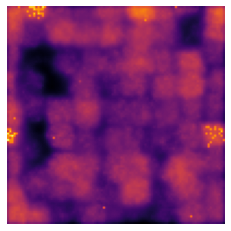

In [10]:
#Plot the expression intensity 
plt.imshow(np.log2(np.sum(pixels,axis=(2,3))+1),
          cmap='inferno')
plt.axis('off')

# Initialize segmentation with watershed on distance transform
max_dist_to_nuclei: maximum distance from the edge of the nucleus ($\mu$) for a pixel to be assigned to a specific nucleus. We start conservative with a maximum radius of 3

In [11]:
max_dist_to_nuclei = 3
cell_assignment = classify_pixels_to_nuclei(locations, nuclei, max_dist_to_nuclei)

/home/russell/miniconda3/envs/tf/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass n_neighbors=1 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


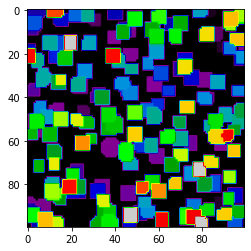

In [12]:
plot_segmentation(cell_assignment,
                 'nipy_spectral')

Count the number of surroundings around each pixel that are the same and different.  
These are used later in the reclassification step

In [13]:
surr_counts, same_count = get_number_similar_surroundings(cell_assignment)

In [ ]:
pref = ''